In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

processed = Path("../data/processed")
datafile = processed / "whatsapp-20240213-185141.parq"
if not datafile.exists():
    logger.warning("Datafile does not exist. First run src/preprocess.py, and check the timestamp!")

In [3]:
df = pd.read_parquet(datafile)
df

,timestamp,author,message,has_emoji
0,2023-11-21 17:53:00,Unknown,21-11-2023 17:53 - ‎~ Fabian Wientjes heeft de...,False
1,2023-11-21 17:57:00,Unknown,21-11-2023 17:57 - ‎~ Fabian Wientjes heeft u ...,False
2,2023-11-21 18:01:00,+31 6 30192692,"21-11-2023 18:01 - +31 6 30192692: Hi allen,\n...",True
3,2023-11-22 09:51:00,+31 6 30192692,22-11-2023 09:51 - +31 6 30192692: Goedemorgen...,False
4,2023-11-22 11:50:00,Unknown,22-11-2023 11:50 - ‎~ Fabian Wientjes heeft de...,False
...,...,...,...,...
108,2024-02-13 09:45:00,+31 6 30192692,13-02-2024 09:45 - +31 6 30192692: Ha allen!\n...,False
109,2024-02-13 09:46:00,+31 6 16080734,13-02-2024 09:46 - +31 6 16080734: <Media wegg...,False
110,2024-02-13 09:48:00,Falco,"Dat is een mooie bericht, iedere gefeliciteer...",False
111,2024-02-13 11:07:00,+31 6 51586398,13-02-2024 11:07 - +31 6 51586398: Bedankt Pau...,False


Let's extract some more info from the timestamp:

In [4]:
df["date"] = df["timestamp"].dt.date
df["isoweek"] = df["timestamp"].dt.isocalendar().week
df.head()


,timestamp,author,message,has_emoji,date,isoweek
0,2023-11-21 17:53:00,Unknown,21-11-2023 17:53 - ‎~ Fabian Wientjes heeft de...,False,2023-11-21,47
1,2023-11-21 17:57:00,Unknown,21-11-2023 17:57 - ‎~ Fabian Wientjes heeft u ...,False,2023-11-21,47
2,2023-11-21 18:01:00,+31 6 30192692,"21-11-2023 18:01 - +31 6 30192692: Hi allen,\n...",True,2023-11-21,47
3,2023-11-22 09:51:00,+31 6 30192692,22-11-2023 09:51 - +31 6 30192692: Goedemorgen...,False,2023-11-22,47
4,2023-11-22 11:50:00,Unknown,22-11-2023 11:50 - ‎~ Fabian Wientjes heeft de...,False,2023-11-22,47


Now, we can group by the isoweeks, for example. 
Let's reindex in order to fill the missing weeks.

In [5]:
p = df.groupby("isoweek").count()
p.head()

,timestamp,author,message,has_emoji,date
isoweek,,,,,
2,4,4,4,4,4
3,6,6,6,6,6
4,5,5,5,5,5
5,3,3,3,3,3
6,4,4,4,4,4


<Axes: xlabel='isoweek', ylabel='timestamp'>

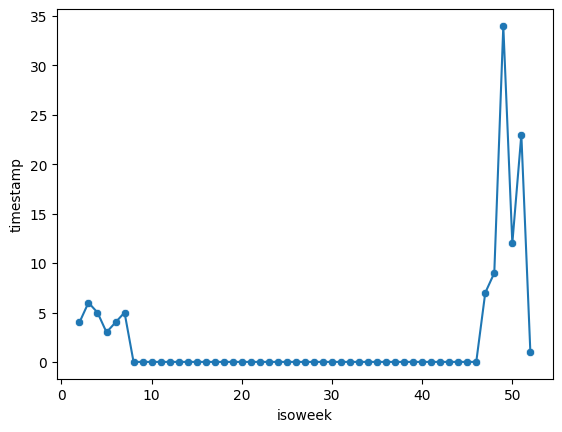

In [6]:
# lets reindex the isoweeks. This wont work if you have multiple years!
p = p.reindex(range(int(p.index.min()), int(p.index.max()) + 1), fill_value=0)
sns.scatterplot(data=p, x="isoweek", y="timestamp")
sns.lineplot(data=p, x="isoweek", y="timestamp")

Try to play with the colors. Make sure adding colors conveys a message, and isnt randomly adding colors.

<Axes: xlabel='isoweek', ylabel='timestamp'>

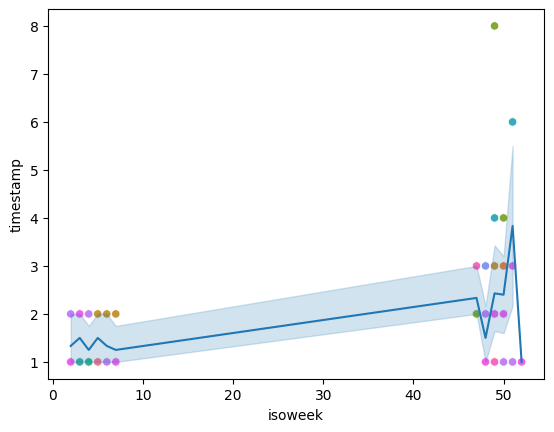

In [7]:
p = df.groupby(["author", "isoweek"]).count()
sns.scatterplot(data=p, x="isoweek", y="timestamp", hue="author", legend=False)
sns.lineplot(data=p, x="isoweek", y="timestamp", legend=False)

In [8]:
df = pd.read_parquet(datafile)
df["date"] = df["timestamp"].dt.date
df["day_of_week"] = df["timestamp"].dt.day_name()
df_agg = df.groupby(['date', 'day_of_week']).size().reset_index(name='message_count')
df_agg

,date,day_of_week,message_count
0,2023-11-21,Tuesday,3
1,2023-11-22,Wednesday,2
2,2023-11-26,Sunday,2
3,2023-11-29,Wednesday,3
4,2023-12-01,Friday,5
5,2023-12-02,Saturday,1
6,2023-12-04,Monday,5
7,2023-12-05,Tuesday,21
8,2023-12-06,Wednesday,4
9,2023-12-07,Thursday,4


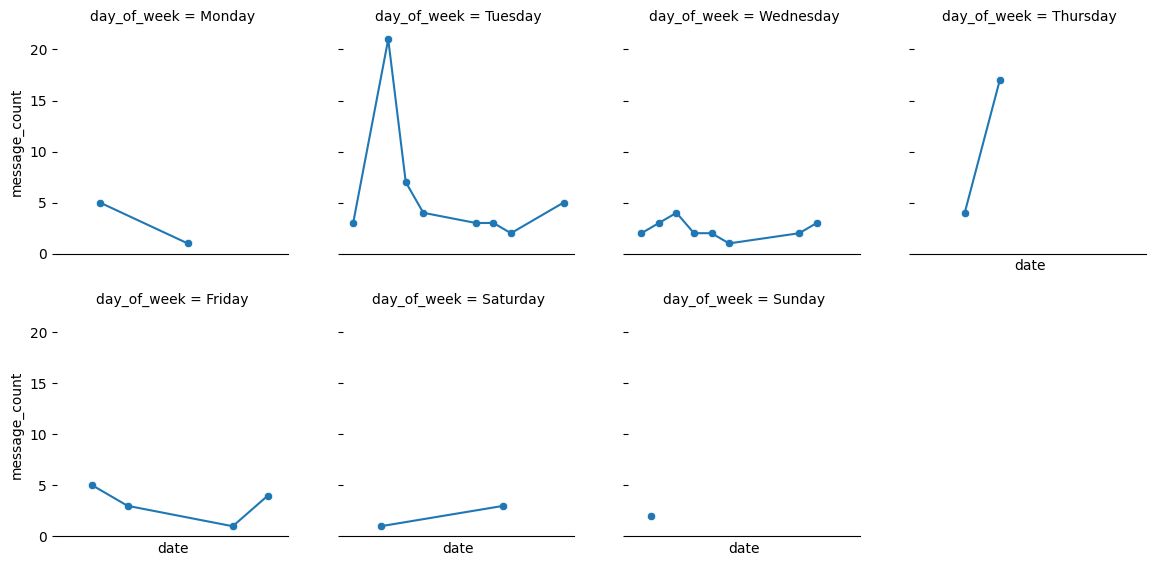

In [9]:

# Set the order of the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a FacetGrid to plot the line plots for each day of the week
g = sns.FacetGrid(df_agg, col='day_of_week', col_wrap=4, height=3, col_order=days_order)
g.map(sns.scatterplot, 'date', 'message_count')
g.map(sns.lineplot, 'date', 'message_count')
g.set(xticks=[])
g.despine(left=True, bottom=False)

In [10]:
df.head()

,timestamp,author,message,has_emoji,date,day_of_week
0,2023-11-21 17:53:00,Unknown,21-11-2023 17:53 - ‎~ Fabian Wientjes heeft de...,False,2023-11-21,Tuesday
1,2023-11-21 17:57:00,Unknown,21-11-2023 17:57 - ‎~ Fabian Wientjes heeft u ...,False,2023-11-21,Tuesday
2,2023-11-21 18:01:00,+31 6 30192692,"21-11-2023 18:01 - +31 6 30192692: Hi allen,\n...",True,2023-11-21,Tuesday
3,2023-11-22 09:51:00,+31 6 30192692,22-11-2023 09:51 - +31 6 30192692: Goedemorgen...,False,2023-11-22,Wednesday
4,2023-11-22 11:50:00,Unknown,22-11-2023 11:50 - ‎~ Fabian Wientjes heeft de...,False,2023-11-22,Wednesday


In [11]:
import plotly.express as px
# first count the number for every category, for every date
p = df.groupby(["date", "timestamp_category"]).size().reset_index(name='message_count')
# then, make the count cumulative for every category
p['cumulative_count'] = p.groupby('timestamp_category')['message_count'].cumsum()

fig = px.area(p, x="date", y="cumulative_count", color="timestamp_category",
              line_group="timestamp_category", labels={"cumulative_count": "Cumulative Message Count"})
fig.show()

KeyError: 'timestamp_category'